<a href="https://www.kaggle.com/code/rahulchauhan016/artguard-ai-advanced-ai-vs-human-art-detection?scriptVersionId=294344553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

#  Imports & Mixed Precision

import os, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
import cv2

mixed_precision.set_global_policy("mixed_float16")
print("TensorFlow:", tf.__version__)
print("Mixed precision enabled")


#  2 – Auto-detect Dataset Root (Multi-class)

BASE_PATH = "/kaggle/input/ai-art-vs-human-art"

def find_dataset_root(base_path):
    for root, dirs, files in os.walk(base_path):
        class_dirs = [d for d in dirs if not d.startswith('.')]
        if len(class_dirs) >= 2:
            return root, class_dirs
    return None, None

DATASET_PATH, CLASS_FOLDERS = find_dataset_root(BASE_PATH)
if DATASET_PATH is None:
    raise ValueError("Dataset root not found")

NUM_CLASSES = len(CLASS_FOLDERS)
CLASS_MODE = "binary" if NUM_CLASSES == 2 else "categorical"
LOSS_FUNCTION = "binary_crossentropy" if NUM_CLASSES == 2 else "categorical_crossentropy"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

print("Dataset root:", DATASET_PATH)
print("Classes:", CLASS_FOLDERS)

#  3 – Data Generators (Strong Augmentation)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset="validation"
)

print("Class mapping:", train_gen.class_indices)


#  4 – Class Weights (Imbalance Handling)


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


#  5 – Build EfficientNetV2S Model

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

if NUM_CLASSES == 2:
    output = Dense(1, activation="sigmoid", dtype="float32")(x)
else:
    output = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) if NUM_CLASSES==2 else tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

model.summary()


#  6 – Callbacks


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]

# 
#  7 – Train Model


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# 8 – Fine Tuning

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=loss_fn,
    metrics=["accuracy"]
)

model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, class_weight=class_weights)


# CELL 9 – Evaluation

val_gen.reset()
preds = model.predict(val_gen)

if NUM_CLASSES == 2:
    pred_labels = (preds > 0.5).astype(int).ravel()
else:
    pred_labels = np.argmax(preds, axis=1)

true_labels = val_gen.classes
print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels))


#  10 – Save Model

model.save("ai_vs_real_advanced_model.keras")
print("Model saved")


# 11 – Prediction (Top-3 + Image Display)

from tensorflow.keras.preprocessing import image

def predict_top3(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, 0)
    preds = model.predict(arr)[0]

    if NUM_CLASSES == 2:
        p = float(preds[0])
        probs = np.array([1-p, p])
    else:
        probs = preds

    class_names = list(train_gen.class_indices.keys())
    top3 = np.argsort(probs)[-3:][::-1]

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    for i in top3:
        print(class_names[i], f"{probs[i]*100:.2f}%")


# 12 – Grad-CAM Utilities

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


#  13 – Grad-CAM Single Image

def show_gradcam(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img)
    inp = np.expand_dims(arr/255.0,0)

    preds = model.predict(inp)[0]
    if NUM_CLASSES==2:
        probs = np.array([1-float(preds[0]), float(preds[0])])
    else:
        probs = preds

    idx = np.argmax(probs)
    heatmap = make_gradcam_heatmap(inp, model, last_conv_layer_name, idx)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(arr.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(arr.astype(np.uint8)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("GradCAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()


# 14 – Slideshow to MP4 with Live Accuracy

def slideshow_to_video_with_accuracy(dataset_path, output_video="slideshow.mp4", fps=1, max_images=50):
    image_files = []
    for r, d, f in os.walk(dataset_path):
        for file in f:
            if file.lower().endswith((".jpg",".png",".jpeg")):
                image_files.append(os.path.join(r,file))
    image_files = image_files[:max_images]

    class_names = list(train_gen.class_indices.keys())

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(output_video, fourcc, fps, (IMG_SIZE, IMG_SIZE))

    correct = 0; total = 0

    for img_path in image_files:
        clear_output(wait=True)

        rel = os.path.relpath(img_path, DATASET_PATH)
        true_class = rel.split(os.sep)[0]

        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        arr = image.img_to_array(img)
        inp = np.expand_dims(arr/255.0,0)

        preds = model.predict(inp, verbose=0)[0]
        if NUM_CLASSES==2:
            probs = np.array([1-float(preds[0]), float(preds[0])])
        else:
            probs = preds

        idx = np.argmax(probs)
        pred_class = class_names[idx]
        conf = probs[idx]*100

        total+=1
        if pred_class==true_class: correct+=1
        acc = correct/total*100

        disp = arr.astype(np.uint8).copy()
        cv2.putText(disp, f"PRED: {pred_class} {conf:.1f}%", (10,25), cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)
        cv2.putText(disp, f"TRUE: {true_class}", (10,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,0),2)
        col=(0,255,0) if acc>=90 else (0,0,255)
        cv2.putText(disp, f"ACC: {acc:.2f}%", (10,75), cv2.FONT_HERSHEY_SIMPLEX,0.6,col,2)

        plt.imshow(disp); plt.axis("off"); plt.show()
        video.write(cv2.cvtColor(disp, cv2.COLOR_RGB2BGR))

    video.release()
    clear_output()
    print("Video saved:", output_video)
    print("Final accuracy:", acc)


# 15 – End

print("Advanced AI vs Real Art pipeline ready 🚀")


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


/usr/local/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow: 2.20.0
Mixed precision enabled
Dataset root: /kaggle/input/ai-art-vs-human-art/Art
Classes: ['RealArt', 'AiArtData']


Found 777 images belonging to 2 classes.


Found 193 images belonging to 2 classes.


Class mapping: {'AiArtData': 0, 'RealArt': 1}
Class weights: {0: np.float64(0.9055944055944056), 1: np.float64(1.1163793103448276)}


       0/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 6299648/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

23584768/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

40583168/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58998784/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

64249856/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

81412096/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 21,123,937 (80.58 MB)

 Trainable params: 790,017 (3.01 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

Epoch 1/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 6:34 16s/step - accuracy: 0.6250 - loss: 0.7949

 2/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5781 - loss: 0.8005  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5486 - loss: 0.8244

 4/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5326 - loss: 0.8299

 5/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5210 - loss: 0.8348

 6/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5115 - loss: 0.8413

 7/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5073 - loss: 0.8457

 8/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5029 - loss: 0.8525

 9/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4991 - loss: 0.8578

10/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4961 - loss: 0.8645

11/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4936 - loss: 0.8705

12/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4933 - loss: 0.8739

13/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4938 - loss: 0.8762

14/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4947 - loss: 0.8782

15/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4958 - loss: 0.8791

16/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4966 - loss: 0.8798 

17/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4980 - loss: 0.8795

18/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4992 - loss: 0.8793

19/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5005 - loss: 0.8790

20/25 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5014 - loss: 0.8784

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5019 - loss: 0.8783

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5024 - loss: 0.8780

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5026 - loss: 0.8778

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5028 - loss: 0.8777

/usr/local/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5030 - loss: 0.8774

25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5097 - loss: 0.8688 - val_accuracy: 0.5078 - val_loss: 0.6929 - learning_rate: 3.0000e-04


Epoch 2/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5938 - loss: 0.8552

 2/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6016 - loss: 0.8481

 3/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6128 - loss: 0.8293

 4/25 ━━━━━━━━━━━━━━━━━━━━ 19s 907ms/step - accuracy: 0.6100 - loss: 0.8306

 5/25 ━━━━━━━━━━━━━━━━━━━━ 16s 843ms/step - accuracy: 0.6030 - loss: 0.8350

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 851ms/step - accuracy: 0.5980 - loss: 0.8348

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 842ms/step - accuracy: 0.5948 - loss: 0.8320

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/step - accuracy: 0.5908 - loss: 0.8310

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 857ms/step - accuracy: 0.5877 - loss: 0.8287

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 847ms/step - accuracy: 0.5848 - loss: 0.8264

11/25 ━━━━━━━━━━━━━━━━━━━━ 12s 878ms/step - accuracy: 0.5818 - loss: 0.8273

12/25 ━━━━━━━━━━━━━━━━━━━━ 11s 888ms/step - accuracy: 0.5786 - loss: 0.8288

13/25 ━━━━━━━━━━━━━━━━━━━━ 10s 869ms/step - accuracy: 0.5761 - loss: 0.8297

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 889ms/step - accuracy: 0.5737 - loss: 0.8303 

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step - accuracy: 0.5709 - loss: 0.8311

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 873ms/step - accuracy: 0.5686 - loss: 0.8318

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 837ms/step - accuracy: 0.5665 - loss: 0.8327

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 831ms/step - accuracy: 0.5648 - loss: 0.8329

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 821ms/step - accuracy: 0.5634 - loss: 0.8330

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.5620 - loss: 0.8332

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - accuracy: 0.5609 - loss: 0.8329

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step - accuracy: 0.5595 - loss: 0.8333

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step - accuracy: 0.5584 - loss: 0.8336

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.5576 - loss: 0.8337

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5571 - loss: 0.8335

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5444 - loss: 0.8301 - val_accuracy: 0.5492 - val_loss: 0.6851 - learning_rate: 3.0000e-04


Epoch 3/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5625 - loss: 0.9560

 2/25 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step - accuracy: 0.5391 - loss: 0.9126

 3/25 ━━━━━━━━━━━━━━━━━━━━ 16s 761ms/step - accuracy: 0.5330 - loss: 0.8963

 4/25 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - accuracy: 0.5345 - loss: 0.8904

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 866ms/step - accuracy: 0.5339 - loss: 0.8863

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 866ms/step - accuracy: 0.5343 - loss: 0.8792

 7/25 ━━━━━━━━━━━━━━━━━━━━ 13s 772ms/step - accuracy: 0.5354 - loss: 0.8748

 8/25 ━━━━━━━━━━━━━━━━━━━━ 12s 764ms/step - accuracy: 0.5361 - loss: 0.8720

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step - accuracy: 0.5377 - loss: 0.8671

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 769ms/step - accuracy: 0.5378 - loss: 0.8638

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accuracy: 0.5384 - loss: 0.8603

12/25 ━━━━━━━━━━━━━━━━━━━━ 9s 761ms/step - accuracy: 0.5388 - loss: 0.8572 

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 783ms/step - accuracy: 0.5394 - loss: 0.8537

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 779ms/step - accuracy: 0.5401 - loss: 0.8505

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 776ms/step - accuracy: 0.5407 - loss: 0.8477

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step - accuracy: 0.5413 - loss: 0.8453

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 790ms/step - accuracy: 0.5417 - loss: 0.8438

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step - accuracy: 0.5423 - loss: 0.8420

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.5427 - loss: 0.8408

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 808ms/step - accuracy: 0.5430 - loss: 0.8403

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.5435 - loss: 0.8396

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - accuracy: 0.5437 - loss: 0.8392

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 0.5438 - loss: 0.8387

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.5437 - loss: 0.8382

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5436 - loss: 0.8377

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 997ms/step - accuracy: 0.5418 - loss: 0.8249 - val_accuracy: 0.4819 - val_loss: 0.6892 - learning_rate: 3.0000e-04


Epoch 4/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5625 - loss: 0.6172

 2/25 ━━━━━━━━━━━━━━━━━━━━ 15s 672ms/step - accuracy: 0.5938 - loss: 0.6155

 3/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6042 - loss: 0.6399   

 4/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6035 - loss: 0.6552

 5/25 ━━━━━━━━━━━━━━━━━━━━ 19s 982ms/step - accuracy: 0.5928 - loss: 0.6754

 6/25 ━━━━━━━━━━━━━━━━━━━━ 17s 926ms/step - accuracy: 0.5834 - loss: 0.6896

 7/25 ━━━━━━━━━━━━━━━━━━━━ 16s 894ms/step - accuracy: 0.5747 - loss: 0.7054

 8/25 ━━━━━━━━━━━━━━━━━━━━ 15s 910ms/step - accuracy: 0.5712 - loss: 0.7141

 9/25 ━━━━━━━━━━━━━━━━━━━━ 14s 883ms/step - accuracy: 0.5687 - loss: 0.7209

10/25 ━━━━━━━━━━━━━━━━━━━━ 13s 876ms/step - accuracy: 0.5646 - loss: 0.7279

11/25 ━━━━━━━━━━━━━━━━━━━━ 12s 870ms/step - accuracy: 0.5616 - loss: 0.7339

12/25 ━━━━━━━━━━━━━━━━━━━━ 11s 867ms/step - accuracy: 0.5586 - loss: 0.7392

13/25 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - accuracy: 0.5560 - loss: 0.7438

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 851ms/step - accuracy: 0.5541 - loss: 0.7475 

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 843ms/step - accuracy: 0.5521 - loss: 0.7509

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 858ms/step - accuracy: 0.5511 - loss: 0.7537

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 853ms/step - accuracy: 0.5504 - loss: 0.7561

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 856ms/step - accuracy: 0.5501 - loss: 0.7580

19/25 ━━━━━━━━━━━━━━━━━━━━ 5s 846ms/step - accuracy: 0.5500 - loss: 0.7596

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 838ms/step - accuracy: 0.5499 - loss: 0.7608

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step - accuracy: 0.5499 - loss: 0.7620

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step - accuracy: 0.5499 - loss: 0.7630

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step - accuracy: 0.5499 - loss: 0.7642

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.5500 - loss: 0.7652

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.5499 - loss: 0.7663

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 990ms/step - accuracy: 0.5483 - loss: 0.7917 - val_accuracy: 0.5181 - val_loss: 0.6903 - learning_rate: 3.0000e-04


Epoch 5/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6875 - loss: 0.6219

 2/25 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.6730 - loss: 0.6121

 3/25 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step - accuracy: 0.6587 - loss: 0.6338

 4/25 ━━━━━━━━━━━━━━━━━━━━ 13s 652ms/step - accuracy: 0.6369 - loss: 0.6558

 5/25 ━━━━━━━━━━━━━━━━━━━━ 13s 657ms/step - accuracy: 0.6234 - loss: 0.6673

 6/25 ━━━━━━━━━━━━━━━━━━━━ 12s 651ms/step - accuracy: 0.6102 - loss: 0.6789

 7/25 ━━━━━━━━━━━━━━━━━━━━ 11s 651ms/step - accuracy: 0.6055 - loss: 0.6867

 8/25 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - accuracy: 0.6017 - loss: 0.6923

 9/25 ━━━━━━━━━━━━━━━━━━━━ 11s 715ms/step - accuracy: 0.5990 - loss: 0.6975

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 746ms/step - accuracy: 0.5970 - loss: 0.7017

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 756ms/step - accuracy: 0.5938 - loss: 0.7066

12/25 ━━━━━━━━━━━━━━━━━━━━ 9s 753ms/step - accuracy: 0.5915 - loss: 0.7103 

13/25 ━━━━━━━━━━━━━━━━━━━━ 8s 746ms/step - accuracy: 0.5890 - loss: 0.7138

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 746ms/step - accuracy: 0.5861 - loss: 0.7174

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.5838 - loss: 0.7201

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 763ms/step - accuracy: 0.5814 - loss: 0.7230

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 795ms/step - accuracy: 0.5793 - loss: 0.7255

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 809ms/step - accuracy: 0.5776 - loss: 0.7278

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.5760 - loss: 0.7298

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.5747 - loss: 0.7314

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.5736 - loss: 0.7328

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 818ms/step - accuracy: 0.5723 - loss: 0.7344

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.5711 - loss: 0.7361

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5702 - loss: 0.7375

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5693 - loss: 0.7388

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5483 - loss: 0.7686 - val_accuracy: 0.5544 - val_loss: 0.6850 - learning_rate: 3.0000e-04


Epoch 6/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6562 - loss: 0.6715

 2/25 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - accuracy: 0.6328 - loss: 0.6759

 3/25 ━━━━━━━━━━━━━━━━━━━━ 17s 801ms/step - accuracy: 0.6094 - loss: 0.6838

 4/25 ━━━━━━━━━━━━━━━━━━━━ 17s 827ms/step - accuracy: 0.5898 - loss: 0.6943

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 878ms/step - accuracy: 0.5744 - loss: 0.7117

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 861ms/step - accuracy: 0.5681 - loss: 0.7191

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 824ms/step - accuracy: 0.5622 - loss: 0.7236

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 798ms/step - accuracy: 0.5598 - loss: 0.7253

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 789ms/step - accuracy: 0.5562 - loss: 0.7296

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 822ms/step - accuracy: 0.5540 - loss: 0.7335

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 806ms/step - accuracy: 0.5512 - loss: 0.7380

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 810ms/step - accuracy: 0.5487 - loss: 0.7423

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 810ms/step - accuracy: 0.5466 - loss: 0.7453 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - accuracy: 0.5445 - loss: 0.7478

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step - accuracy: 0.5434 - loss: 0.7497

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 0.5420 - loss: 0.7511

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - accuracy: 0.5407 - loss: 0.7527

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 791ms/step - accuracy: 0.5395 - loss: 0.7542

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - accuracy: 0.5385 - loss: 0.7555

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.5374 - loss: 0.7569

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 789ms/step - accuracy: 0.5363 - loss: 0.7581

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step - accuracy: 0.5354 - loss: 0.7589

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step - accuracy: 0.5345 - loss: 0.7597

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.5338 - loss: 0.7606

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5334 - loss: 0.7610

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5238 - loss: 0.7727 - val_accuracy: 0.5959 - val_loss: 0.6844 - learning_rate: 9.0000e-05


Epoch 7/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4688 - loss: 0.8355

 2/25 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - accuracy: 0.5000 - loss: 0.7853

 3/25 ━━━━━━━━━━━━━━━━━━━━ 19s 884ms/step - accuracy: 0.5069 - loss: 0.7793

 4/25 ━━━━━━━━━━━━━━━━━━━━ 19s 922ms/step - accuracy: 0.5091 - loss: 0.7735

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 859ms/step - accuracy: 0.5098 - loss: 0.7674

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 856ms/step - accuracy: 0.5108 - loss: 0.7666

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 868ms/step - accuracy: 0.5137 - loss: 0.7624

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 838ms/step - accuracy: 0.5178 - loss: 0.7570

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 817ms/step - accuracy: 0.5213 - loss: 0.7524

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 854ms/step - accuracy: 0.5241 - loss: 0.7488

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 844ms/step - accuracy: 0.5263 - loss: 0.7463

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 838ms/step - accuracy: 0.5285 - loss: 0.7454

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 823ms/step - accuracy: 0.5298 - loss: 0.7445 

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 825ms/step - accuracy: 0.5315 - loss: 0.7433

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - accuracy: 0.5327 - loss: 0.7420

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 814ms/step - accuracy: 0.5337 - loss: 0.7405

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step - accuracy: 0.5347 - loss: 0.7396

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - accuracy: 0.5360 - loss: 0.7385

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 806ms/step - accuracy: 0.5372 - loss: 0.7374

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 821ms/step - accuracy: 0.5387 - loss: 0.7362

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - accuracy: 0.5401 - loss: 0.7351

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.5414 - loss: 0.7342

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - accuracy: 0.5428 - loss: 0.7335

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5438 - loss: 0.7332

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.5447 - loss: 0.7329

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5650 - loss: 0.7251 - val_accuracy: 0.5959 - val_loss: 0.6834 - learning_rate: 9.0000e-05


Epoch 8/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5938 - loss: 0.7189

 2/25 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step - accuracy: 0.5859 - loss: 0.7074

 3/25 ━━━━━━━━━━━━━━━━━━━━ 19s 903ms/step - accuracy: 0.5712 - loss: 0.7080

 4/25 ━━━━━━━━━━━━━━━━━━━━ 18s 859ms/step - accuracy: 0.5632 - loss: 0.7114

 5/25 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - accuracy: 0.5630 - loss: 0.7112

 6/25 ━━━━━━━━━━━━━━━━━━━━ 15s 794ms/step - accuracy: 0.5664 - loss: 0.7112

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 782ms/step - accuracy: 0.5639 - loss: 0.7156

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - accuracy: 0.5647 - loss: 0.7193

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - accuracy: 0.5660 - loss: 0.7209

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 846ms/step - accuracy: 0.5679 - loss: 0.7211

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 831ms/step - accuracy: 0.5694 - loss: 0.7218

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 824ms/step - accuracy: 0.5706 - loss: 0.7223

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 816ms/step - accuracy: 0.5703 - loss: 0.7240 

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 852ms/step - accuracy: 0.5698 - loss: 0.7259

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 843ms/step - accuracy: 0.5690 - loss: 0.7281

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 831ms/step - accuracy: 0.5680 - loss: 0.7303

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 840ms/step - accuracy: 0.5671 - loss: 0.7323

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 834ms/step - accuracy: 0.5661 - loss: 0.7340

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 823ms/step - accuracy: 0.5651 - loss: 0.7354

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - accuracy: 0.5641 - loss: 0.7369

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.5631 - loss: 0.7382

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - accuracy: 0.5625 - loss: 0.7393

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - accuracy: 0.5617 - loss: 0.7403

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.5612 - loss: 0.7413

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.5604 - loss: 0.7420

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5431 - loss: 0.7600 - val_accuracy: 0.6373 - val_loss: 0.6799 - learning_rate: 9.0000e-05


Epoch 9/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6250 - loss: 0.7031

 2/25 ━━━━━━━━━━━━━━━━━━━━ 14s 644ms/step - accuracy: 0.5938 - loss: 0.7254

 3/25 ━━━━━━━━━━━━━━━━━━━━ 19s 895ms/step - accuracy: 0.5764 - loss: 0.7271

 4/25 ━━━━━━━━━━━━━━━━━━━━ 17s 833ms/step - accuracy: 0.5612 - loss: 0.7318

 5/25 ━━━━━━━━━━━━━━━━━━━━ 15s 794ms/step - accuracy: 0.5590 - loss: 0.7350

 6/25 ━━━━━━━━━━━━━━━━━━━━ 15s 807ms/step - accuracy: 0.5587 - loss: 0.7374

 7/25 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - accuracy: 0.5548 - loss: 0.7423

 8/25 ━━━━━━━━━━━━━━━━━━━━ 12s 761ms/step - accuracy: 0.5528 - loss: 0.7446

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 752ms/step - accuracy: 0.5512 - loss: 0.7460

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 747ms/step - accuracy: 0.5495 - loss: 0.7470

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 745ms/step - accuracy: 0.5481 - loss: 0.7479

12/25 ━━━━━━━━━━━━━━━━━━━━ 9s 761ms/step - accuracy: 0.5463 - loss: 0.7493 

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 787ms/step - accuracy: 0.5455 - loss: 0.7499

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 791ms/step - accuracy: 0.5445 - loss: 0.7504

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 791ms/step - accuracy: 0.5443 - loss: 0.7503

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step - accuracy: 0.5439 - loss: 0.7507

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 795ms/step - accuracy: 0.5441 - loss: 0.7506

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 802ms/step - accuracy: 0.5443 - loss: 0.7506

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - accuracy: 0.5445 - loss: 0.7505

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 788ms/step - accuracy: 0.5447 - loss: 0.7504

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - accuracy: 0.5445 - loss: 0.7504

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - accuracy: 0.5444 - loss: 0.7502

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - accuracy: 0.5443 - loss: 0.7501

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.5444 - loss: 0.7497

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5446 - loss: 0.7493

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1000ms/step - accuracy: 0.5495 - loss: 0.7385 - val_accuracy: 0.5803 - val_loss: 0.6818 - learning_rate: 9.0000e-05


Epoch 10/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4375 - loss: 0.6818

 2/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4453 - loss: 0.7093

 3/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4705 - loss: 0.7236

 4/25 ━━━━━━━━━━━━━━━━━━━━ 19s 910ms/step - accuracy: 0.4974 - loss: 0.7236

 5/25 ━━━━━━━━━━━━━━━━━━━━ 18s 902ms/step - accuracy: 0.5117 - loss: 0.7288

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 854ms/step - accuracy: 0.5158 - loss: 0.7379

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 855ms/step - accuracy: 0.5155 - loss: 0.7450

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/step - accuracy: 0.5145 - loss: 0.7495

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 802ms/step - accuracy: 0.5160 - loss: 0.7515

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 783ms/step - accuracy: 0.5181 - loss: 0.7518

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 785ms/step - accuracy: 0.5196 - loss: 0.7524

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 784ms/step - accuracy: 0.5216 - loss: 0.7519

13/25 ━━━━━━━━━━━━━━━━━━━━ 8s 743ms/step - accuracy: 0.5232 - loss: 0.7516 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 749ms/step - accuracy: 0.5247 - loss: 0.7513

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - accuracy: 0.5254 - loss: 0.7512

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 775ms/step - accuracy: 0.5261 - loss: 0.7516

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 767ms/step - accuracy: 0.5275 - loss: 0.7515

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.5294 - loss: 0.7510

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 757ms/step - accuracy: 0.5308 - loss: 0.7509

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 771ms/step - accuracy: 0.5321 - loss: 0.7508

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step - accuracy: 0.5332 - loss: 0.7506

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 780ms/step - accuracy: 0.5343 - loss: 0.7504

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.5353 - loss: 0.7502

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.5360 - loss: 0.7502

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.5363 - loss: 0.7504

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5444 - loss: 0.7557 - val_accuracy: 0.5648 - val_loss: 0.6796 - learning_rate: 9.0000e-05


Epoch 11/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4688 - loss: 0.8784

 2/25 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step - accuracy: 0.5000 - loss: 0.8309

 3/25 ━━━━━━━━━━━━━━━━━━━━ 17s 801ms/step - accuracy: 0.5208 - loss: 0.8003

 4/25 ━━━━━━━━━━━━━━━━━━━━ 17s 836ms/step - accuracy: 0.5273 - loss: 0.7894

 5/25 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - accuracy: 0.5381 - loss: 0.7761

 6/25 ━━━━━━━━━━━━━━━━━━━━ 14s 763ms/step - accuracy: 0.5474 - loss: 0.7656

 7/25 ━━━━━━━━━━━━━━━━━━━━ 13s 750ms/step - accuracy: 0.5553 - loss: 0.7557

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 798ms/step - accuracy: 0.5621 - loss: 0.7480

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 787ms/step - accuracy: 0.5667 - loss: 0.7426

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 778ms/step - accuracy: 0.5704 - loss: 0.7381

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 770ms/step - accuracy: 0.5720 - loss: 0.7353

12/25 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step - accuracy: 0.5729 - loss: 0.7334 

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 781ms/step - accuracy: 0.5734 - loss: 0.7324

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step - accuracy: 0.5739 - loss: 0.7316

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.5743 - loss: 0.7309

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 745ms/step - accuracy: 0.5750 - loss: 0.7300

17/25 ━━━━━━━━━━━━━━━━━━━━ 5s 739ms/step - accuracy: 0.5755 - loss: 0.7293

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 746ms/step - accuracy: 0.5758 - loss: 0.7290

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - accuracy: 0.5759 - loss: 0.7285

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - accuracy: 0.5764 - loss: 0.7279

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - accuracy: 0.5765 - loss: 0.7275

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 752ms/step - accuracy: 0.5766 - loss: 0.7271

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - accuracy: 0.5767 - loss: 0.7267

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.5769 - loss: 0.7263

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5768 - loss: 0.7261

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5753 - loss: 0.7212 - val_accuracy: 0.6425 - val_loss: 0.6732 - learning_rate: 9.0000e-05


Epoch 12/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5312 - loss: 0.6704

 2/25 ━━━━━━━━━━━━━━━━━━━━ 21s 951ms/step - accuracy: 0.5625 - loss: 0.6472

 3/25 ━━━━━━━━━━━━━━━━━━━━ 19s 883ms/step - accuracy: 0.5625 - loss: 0.6553

 4/25 ━━━━━━━━━━━━━━━━━━━━ 18s 903ms/step - accuracy: 0.5645 - loss: 0.6625

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 884ms/step - accuracy: 0.5691 - loss: 0.6673

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 845ms/step - accuracy: 0.5714 - loss: 0.6721

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 810ms/step - accuracy: 0.5695 - loss: 0.6778

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 799ms/step - accuracy: 0.5677 - loss: 0.6832

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.5675 - loss: 0.6876

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 822ms/step - accuracy: 0.5657 - loss: 0.6919

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 834ms/step - accuracy: 0.5657 - loss: 0.6950

12/25 ━━━━━━━━━━━━━━━━━━━━ 11s 879ms/step - accuracy: 0.5659 - loss: 0.6977

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 830ms/step - accuracy: 0.5660 - loss: 0.6998 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - accuracy: 0.5664 - loss: 0.7012

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - accuracy: 0.5660 - loss: 0.7030

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 804ms/step - accuracy: 0.5654 - loss: 0.7048

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - accuracy: 0.5654 - loss: 0.7063

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 808ms/step - accuracy: 0.5656 - loss: 0.7074

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.5657 - loss: 0.7083

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.5658 - loss: 0.7090

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.5656 - loss: 0.7098

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 806ms/step - accuracy: 0.5653 - loss: 0.7107

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step - accuracy: 0.5649 - loss: 0.7116

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.5643 - loss: 0.7123

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.5638 - loss: 0.7130

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5521 - loss: 0.7285 - val_accuracy: 0.5855 - val_loss: 0.6697 - learning_rate: 9.0000e-05


Epoch 13/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5312 - loss: 0.7519

 2/25 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - accuracy: 0.5547 - loss: 0.7126

 3/25 ━━━━━━━━━━━━━━━━━━━━ 15s 717ms/step - accuracy: 0.5712 - loss: 0.6893

 4/25 ━━━━━━━━━━━━━━━━━━━━ 19s 921ms/step - accuracy: 0.5788 - loss: 0.6842

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 857ms/step - accuracy: 0.5818 - loss: 0.6844

 6/25 ━━━━━━━━━━━━━━━━━━━━ 15s 816ms/step - accuracy: 0.5829 - loss: 0.6871

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 829ms/step - accuracy: 0.5864 - loss: 0.6875

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 831ms/step - accuracy: 0.5883 - loss: 0.6890

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 842ms/step - accuracy: 0.5896 - loss: 0.6900

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 819ms/step - accuracy: 0.5901 - loss: 0.6920

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 812ms/step - accuracy: 0.5888 - loss: 0.6944

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 805ms/step - accuracy: 0.5869 - loss: 0.6970

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 803ms/step - accuracy: 0.5846 - loss: 0.6996 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 792ms/step - accuracy: 0.5827 - loss: 0.7017

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step - accuracy: 0.5811 - loss: 0.7038

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 749ms/step - accuracy: 0.5804 - loss: 0.7051

17/25 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step - accuracy: 0.5797 - loss: 0.7064

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 0.5789 - loss: 0.7078

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 766ms/step - accuracy: 0.5781 - loss: 0.7091

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - accuracy: 0.5773 - loss: 0.7103

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - accuracy: 0.5766 - loss: 0.7114

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 781ms/step - accuracy: 0.5761 - loss: 0.7123

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - accuracy: 0.5756 - loss: 0.7132

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.5752 - loss: 0.7141

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.5747 - loss: 0.7149

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 984ms/step - accuracy: 0.5637 - loss: 0.7343 - val_accuracy: 0.6477 - val_loss: 0.6704 - learning_rate: 9.0000e-05


Epoch 14/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4375 - loss: 0.7159

 2/25 ━━━━━━━━━━━━━━━━━━━━ 18s 825ms/step - accuracy: 0.4922 - loss: 0.7320

 3/25 ━━━━━━━━━━━━━━━━━━━━ 18s 832ms/step - accuracy: 0.4844 - loss: 0.7420

 4/25 ━━━━━━━━━━━━━━━━━━━━ 18s 859ms/step - accuracy: 0.4922 - loss: 0.7389

 5/25 ━━━━━━━━━━━━━━━━━━━━ 17s 851ms/step - accuracy: 0.5038 - loss: 0.7351

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 851ms/step - accuracy: 0.5118 - loss: 0.7305

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 823ms/step - accuracy: 0.5197 - loss: 0.7289

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 811ms/step - accuracy: 0.5255 - loss: 0.7277

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 791ms/step - accuracy: 0.5308 - loss: 0.7271

10/25 ━━━━━━━━━━━━━━━━━━━━ 11s 776ms/step - accuracy: 0.5346 - loss: 0.7270

11/25 ━━━━━━━━━━━━━━━━━━━━ 10s 772ms/step - accuracy: 0.5374 - loss: 0.7268

12/25 ━━━━━━━━━━━━━━━━━━━━ 9s 765ms/step - accuracy: 0.5399 - loss: 0.7262 

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step - accuracy: 0.5415 - loss: 0.7257

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 747ms/step - accuracy: 0.5425 - loss: 0.7250

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.5440 - loss: 0.7241

16/25 ━━━━━━━━━━━━━━━━━━━━ 6s 747ms/step - accuracy: 0.5452 - loss: 0.7235

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 756ms/step - accuracy: 0.5465 - loss: 0.7226

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step - accuracy: 0.5476 - loss: 0.7219

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 776ms/step - accuracy: 0.5484 - loss: 0.7211

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 793ms/step - accuracy: 0.5493 - loss: 0.7205

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.5499 - loss: 0.7201

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step - accuracy: 0.5506 - loss: 0.7197

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - accuracy: 0.5511 - loss: 0.7195

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5515 - loss: 0.7196

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.5520 - loss: 0.7197

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5650 - loss: 0.7211 - val_accuracy: 0.6114 - val_loss: 0.6694 - learning_rate: 9.0000e-05


Epoch 15/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4375 - loss: 0.6721

 2/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4766 - loss: 0.6916

 3/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4983 - loss: 0.6961

 4/25 ━━━━━━━━━━━━━━━━━━━━ 20s 984ms/step - accuracy: 0.5065 - loss: 0.7033

 5/25 ━━━━━━━━━━━━━━━━━━━━ 18s 927ms/step - accuracy: 0.5140 - loss: 0.7048

 6/25 ━━━━━━━━━━━━━━━━━━━━ 17s 901ms/step - accuracy: 0.5238 - loss: 0.7029

 7/25 ━━━━━━━━━━━━━━━━━━━━ 16s 919ms/step - accuracy: 0.5300 - loss: 0.7020

 8/25 ━━━━━━━━━━━━━━━━━━━━ 15s 889ms/step - accuracy: 0.5345 - loss: 0.7007

 9/25 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - accuracy: 0.5380 - loss: 0.7000

10/25 ━━━━━━━━━━━━━━━━━━━━ 13s 893ms/step - accuracy: 0.5414 - loss: 0.6999

11/25 ━━━━━━━━━━━━━━━━━━━━ 12s 867ms/step - accuracy: 0.5443 - loss: 0.6995

12/25 ━━━━━━━━━━━━━━━━━━━━ 11s 866ms/step - accuracy: 0.5469 - loss: 0.6989

13/25 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - accuracy: 0.5489 - loss: 0.6985

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 844ms/step - accuracy: 0.5499 - loss: 0.6984 

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 847ms/step - accuracy: 0.5511 - loss: 0.6983

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 835ms/step - accuracy: 0.5526 - loss: 0.6981

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 857ms/step - accuracy: 0.5534 - loss: 0.6983

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 847ms/step - accuracy: 0.5542 - loss: 0.6987

19/25 ━━━━━━━━━━━━━━━━━━━━ 5s 837ms/step - accuracy: 0.5549 - loss: 0.6990

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 827ms/step - accuracy: 0.5558 - loss: 0.6991

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 819ms/step - accuracy: 0.5567 - loss: 0.6988

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.5575 - loss: 0.6990

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 0.5580 - loss: 0.6991

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.5585 - loss: 0.6991

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.5589 - loss: 0.6993

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5689 - loss: 0.7055 - val_accuracy: 0.5959 - val_loss: 0.6742 - learning_rate: 9.0000e-05


Epoch 16/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5000 - loss: 0.7197

 2/25 ━━━━━━━━━━━━━━━━━━━━ 19s 831ms/step - accuracy: 0.5156 - loss: 0.7449

 3/25 ━━━━━━━━━━━━━━━━━━━━ 17s 805ms/step - accuracy: 0.5035 - loss: 0.7508

 4/25 ━━━━━━━━━━━━━━━━━━━━ 15s 757ms/step - accuracy: 0.5085 - loss: 0.7470

 5/25 ━━━━━━━━━━━━━━━━━━━━ 14s 748ms/step - accuracy: 0.5093 - loss: 0.7432

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 863ms/step - accuracy: 0.5121 - loss: 0.7402

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 834ms/step - accuracy: 0.5174 - loss: 0.7374

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 841ms/step - accuracy: 0.5225 - loss: 0.7369

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - accuracy: 0.5254 - loss: 0.7375

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 808ms/step - accuracy: 0.5276 - loss: 0.7380

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.5307 - loss: 0.7371

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 799ms/step - accuracy: 0.5332 - loss: 0.7362

13/25 ━━━━━━━━━━━━━━━━━━━━ 10s 834ms/step - accuracy: 0.5351 - loss: 0.7357

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 826ms/step - accuracy: 0.5376 - loss: 0.7344 

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 856ms/step - accuracy: 0.5394 - loss: 0.7333

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 848ms/step - accuracy: 0.5410 - loss: 0.7321

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.5425 - loss: 0.7312

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 836ms/step - accuracy: 0.5440 - loss: 0.7307

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step - accuracy: 0.5453 - loss: 0.7300

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 834ms/step - accuracy: 0.5463 - loss: 0.7294

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 833ms/step - accuracy: 0.5474 - loss: 0.7289

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 832ms/step - accuracy: 0.5486 - loss: 0.7283

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - accuracy: 0.5496 - loss: 0.7277

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.5507 - loss: 0.7270

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.5516 - loss: 0.7266

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5740 - loss: 0.7168 - val_accuracy: 0.5855 - val_loss: 0.6689 - learning_rate: 9.0000e-05


Epoch 17/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7188 - loss: 0.6039

 2/25 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step - accuracy: 0.6484 - loss: 0.6547

 3/25 ━━━━━━━━━━━━━━━━━━━━ 17s 789ms/step - accuracy: 0.6198 - loss: 0.6757

 4/25 ━━━━━━━━━━━━━━━━━━━━ 15s 746ms/step - accuracy: 0.5996 - loss: 0.6872

 5/25 ━━━━━━━━━━━━━━━━━━━━ 15s 766ms/step - accuracy: 0.5884 - loss: 0.6939

 6/25 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.5789 - loss: 0.6997

 7/25 ━━━━━━━━━━━━━━━━━━━━ 14s 828ms/step - accuracy: 0.5753 - loss: 0.7016

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 832ms/step - accuracy: 0.5708 - loss: 0.7046

 9/25 ━━━━━━━━━━━━━━━━━━━━ 13s 828ms/step - accuracy: 0.5664 - loss: 0.7071

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 806ms/step - accuracy: 0.5616 - loss: 0.7093

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 797ms/step - accuracy: 0.5583 - loss: 0.7109

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 785ms/step - accuracy: 0.5561 - loss: 0.7124

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 786ms/step - accuracy: 0.5545 - loss: 0.7135 

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 825ms/step - accuracy: 0.5529 - loss: 0.7144

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 813ms/step - accuracy: 0.5507 - loss: 0.7151

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 803ms/step - accuracy: 0.5482 - loss: 0.7161

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 793ms/step - accuracy: 0.5466 - loss: 0.7164

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step - accuracy: 0.5458 - loss: 0.7166

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 801ms/step - accuracy: 0.5449 - loss: 0.7168

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step - accuracy: 0.5444 - loss: 0.7168

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 810ms/step - accuracy: 0.5444 - loss: 0.7167

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 817ms/step - accuracy: 0.5445 - loss: 0.7166

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 0.5446 - loss: 0.7166

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.5446 - loss: 0.7165

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.5445 - loss: 0.7165

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5418 - loss: 0.7172 - val_accuracy: 0.5803 - val_loss: 0.6747 - learning_rate: 9.0000e-05


Epoch 18/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6562 - loss: 0.6221

 2/25 ━━━━━━━━━━━━━━━━━━━━ 19s 858ms/step - accuracy: 0.6562 - loss: 0.6474

 3/25 ━━━━━━━━━━━━━━━━━━━━ 20s 935ms/step - accuracy: 0.6424 - loss: 0.6611

 4/25 ━━━━━━━━━━━━━━━━━━━━ 19s 913ms/step - accuracy: 0.6243 - loss: 0.6749

 5/25 ━━━━━━━━━━━━━━━━━━━━ 18s 904ms/step - accuracy: 0.6120 - loss: 0.6837

 6/25 ━━━━━━━━━━━━━━━━━━━━ 17s 912ms/step - accuracy: 0.6037 - loss: 0.6878

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 884ms/step - accuracy: 0.5940 - loss: 0.6930

 8/25 ━━━━━━━━━━━━━━━━━━━━ 15s 915ms/step - accuracy: 0.5876 - loss: 0.6956

 9/25 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - accuracy: 0.5833 - loss: 0.6976

10/25 ━━━━━━━━━━━━━━━━━━━━ 13s 868ms/step - accuracy: 0.5784 - loss: 0.6992

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 812ms/step - accuracy: 0.5750 - loss: 0.7003

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 835ms/step - accuracy: 0.5721 - loss: 0.7019

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 827ms/step - accuracy: 0.5708 - loss: 0.7025 

14/25 ━━━━━━━━━━━━━━━━━━━━ 9s 836ms/step - accuracy: 0.5688 - loss: 0.7034

15/25 ━━━━━━━━━━━━━━━━━━━━ 8s 835ms/step - accuracy: 0.5674 - loss: 0.7039

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 837ms/step - accuracy: 0.5668 - loss: 0.7042

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 839ms/step - accuracy: 0.5662 - loss: 0.7045

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 830ms/step - accuracy: 0.5655 - loss: 0.7049

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 830ms/step - accuracy: 0.5652 - loss: 0.7051

20/25 ━━━━━━━━━━━━━━━━━━━━ 4s 821ms/step - accuracy: 0.5650 - loss: 0.7052

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 828ms/step - accuracy: 0.5651 - loss: 0.7052

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step - accuracy: 0.5652 - loss: 0.7052

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - accuracy: 0.5656 - loss: 0.7049

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5658 - loss: 0.7049

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5659 - loss: 0.7049

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5701 - loss: 0.7054 - val_accuracy: 0.6010 - val_loss: 0.6660 - learning_rate: 9.0000e-05


Epoch 19/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5625 - loss: 0.7257

 2/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1000ms/step - accuracy: 0.5469 - loss: 0.7158

 3/25 ━━━━━━━━━━━━━━━━━━━━ 17s 811ms/step - accuracy: 0.5590 - loss: 0.7117 

 4/25 ━━━━━━━━━━━━━━━━━━━━ 15s 756ms/step - accuracy: 0.5677 - loss: 0.7121

 5/25 ━━━━━━━━━━━━━━━━━━━━ 14s 726ms/step - accuracy: 0.5804 - loss: 0.7055

 6/25 ━━━━━━━━━━━━━━━━━━━━ 13s 723ms/step - accuracy: 0.5852 - loss: 0.7052

 7/25 ━━━━━━━━━━━━━━━━━━━━ 13s 724ms/step - accuracy: 0.5884 - loss: 0.7046

 8/25 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - accuracy: 0.5890 - loss: 0.7053

 9/25 ━━━━━━━━━━━━━━━━━━━━ 12s 790ms/step - accuracy: 0.5900 - loss: 0.7053

10/25 ━━━━━━━━━━━━━━━━━━━━ 12s 816ms/step - accuracy: 0.5910 - loss: 0.7051

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 818ms/step - accuracy: 0.5907 - loss: 0.7054

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - accuracy: 0.5899 - loss: 0.7054

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 799ms/step - accuracy: 0.5894 - loss: 0.7052 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 793ms/step - accuracy: 0.5888 - loss: 0.7051

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 792ms/step - accuracy: 0.5879 - loss: 0.7051

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 796ms/step - accuracy: 0.5865 - loss: 0.7052

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.5852 - loss: 0.7054

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - accuracy: 0.5839 - loss: 0.7056

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - accuracy: 0.5830 - loss: 0.7059

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.5820 - loss: 0.7065

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 782ms/step - accuracy: 0.5810 - loss: 0.7069

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step - accuracy: 0.5802 - loss: 0.7073

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - accuracy: 0.5797 - loss: 0.7076

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.5791 - loss: 0.7078

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.5786 - loss: 0.7078

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5663 - loss: 0.7096 - val_accuracy: 0.6321 - val_loss: 0.6589 - learning_rate: 9.0000e-05


Epoch 20/20


 1/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6875 - loss: 0.6064

 2/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6406 - loss: 0.6466

 3/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6181 - loss: 0.6660

 4/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5983 - loss: 0.6881

 5/25 ━━━━━━━━━━━━━━━━━━━━ 18s 941ms/step - accuracy: 0.5836 - loss: 0.7022

 6/25 ━━━━━━━━━━━━━━━━━━━━ 16s 877ms/step - accuracy: 0.5766 - loss: 0.7094

 7/25 ━━━━━━━━━━━━━━━━━━━━ 15s 885ms/step - accuracy: 0.5721 - loss: 0.7142

 8/25 ━━━━━━━━━━━━━━━━━━━━ 14s 863ms/step - accuracy: 0.5699 - loss: 0.7167

 9/25 ━━━━━━━━━━━━━━━━━━━━ 14s 877ms/step - accuracy: 0.5699 - loss: 0.7182

10/25 ━━━━━━━━━━━━━━━━━━━━ 13s 869ms/step - accuracy: 0.5694 - loss: 0.7188

11/25 ━━━━━━━━━━━━━━━━━━━━ 11s 811ms/step - accuracy: 0.5688 - loss: 0.7194

12/25 ━━━━━━━━━━━━━━━━━━━━ 10s 795ms/step - accuracy: 0.5687 - loss: 0.7197

13/25 ━━━━━━━━━━━━━━━━━━━━ 9s 800ms/step - accuracy: 0.5690 - loss: 0.7195 

14/25 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step - accuracy: 0.5690 - loss: 0.7194

15/25 ━━━━━━━━━━━━━━━━━━━━ 7s 784ms/step - accuracy: 0.5689 - loss: 0.7194

16/25 ━━━━━━━━━━━━━━━━━━━━ 7s 782ms/step - accuracy: 0.5689 - loss: 0.7192

17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 784ms/step - accuracy: 0.5688 - loss: 0.7189

18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 808ms/step - accuracy: 0.5691 - loss: 0.7187

19/25 ━━━━━━━━━━━━━━━━━━━━ 4s 804ms/step - accuracy: 0.5690 - loss: 0.7188

20/25 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - accuracy: 0.5691 - loss: 0.7191

21/25 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.5692 - loss: 0.7192

22/25 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step - accuracy: 0.5698 - loss: 0.7189

23/25 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - accuracy: 0.5702 - loss: 0.7186

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.5708 - loss: 0.7183

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5712 - loss: 0.7182

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 987ms/step - accuracy: 0.5817 - loss: 0.7144 - val_accuracy: 0.5337 - val_loss: 0.6695 - learning_rate: 9.0000e-05


Epoch 1/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 8:53 22s/step - accuracy: 0.5000 - loss: 0.7494

 2/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5000 - loss: 0.7499  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5069 - loss: 0.7548

 4/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5169 - loss: 0.7542

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5235 - loss: 0.7505

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5292 - loss: 0.7495

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5320 - loss: 0.7502

 8/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5324 - loss: 0.7536

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5327 - loss: 0.7562

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5335 - loss: 0.7570

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5348 - loss: 0.7579

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5358 - loss: 0.7586

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5366 - loss: 0.7594

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5368 - loss: 0.7597

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5373 - loss: 0.7599

16/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5381 - loss: 0.7596

17/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5387 - loss: 0.7594

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5391 - loss: 0.7591 

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5399 - loss: 0.7586

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5404 - loss: 0.7581

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5406 - loss: 0.7577

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5409 - loss: 0.7572

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5411 - loss: 0.7569

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5412 - loss: 0.7565

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5414 - loss: 0.7562

25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5444 - loss: 0.7489 - val_accuracy: 0.5907 - val_loss: 0.6650 - learning_rate: 1.0000e-05


Epoch 2/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5312 - loss: 0.7855

 2/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5391 - loss: 0.8022

 3/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5399 - loss: 0.7898

 4/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5397 - loss: 0.7903

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5430 - loss: 0.7863

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5454 - loss: 0.7837

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5447 - loss: 0.7818

 8/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5469 - loss: 0.7779

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5494 - loss: 0.7737

10/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5517 - loss: 0.7699

11/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5527 - loss: 0.7678

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5537 - loss: 0.7663

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5538 - loss: 0.7654

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5539 - loss: 0.7645

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5544 - loss: 0.7629

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5544 - loss: 0.7619

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5540 - loss: 0.7615 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5533 - loss: 0.7613

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5525 - loss: 0.7612

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5518 - loss: 0.7610

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5515 - loss: 0.7608

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5512 - loss: 0.7606

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5508 - loss: 0.7603

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5503 - loss: 0.7600

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5498 - loss: 0.7598

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5367 - loss: 0.7565 - val_accuracy: 0.4974 - val_loss: 0.6745 - learning_rate: 1.0000e-05


Epoch 3/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5938 - loss: 0.7540

 2/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5938 - loss: 0.7584

 3/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5868 - loss: 0.7578

 4/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5807 - loss: 0.7584

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5721 - loss: 0.7658

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5661 - loss: 0.7702

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5580 - loss: 0.7758

 8/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5532 - loss: 0.7791

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5484 - loss: 0.7813

10/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5448 - loss: 0.7832

11/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5417 - loss: 0.7847

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5390 - loss: 0.7862

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5369 - loss: 0.7869

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5350 - loss: 0.7877

15/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5327 - loss: 0.7884

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5309 - loss: 0.7894

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5293 - loss: 0.7899 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5284 - loss: 0.7900

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5275 - loss: 0.7903

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5267 - loss: 0.7902

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5263 - loss: 0.7899

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5259 - loss: 0.7896

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5256 - loss: 0.7892

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5251 - loss: 0.7889

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5249 - loss: 0.7884

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5199 - loss: 0.7772 - val_accuracy: 0.5130 - val_loss: 0.6834 - learning_rate: 1.0000e-05


Epoch 4/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.5938 - loss: 0.6933

 2/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5938 - loss: 0.7080 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5868 - loss: 0.7147

 4/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5846 - loss: 0.7163

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5802 - loss: 0.7159

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5790 - loss: 0.7140

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5760 - loss: 0.7145

 8/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5724 - loss: 0.7156

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5709 - loss: 0.7155

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5700 - loss: 0.7160

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5686 - loss: 0.7177

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5664 - loss: 0.7198

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5648 - loss: 0.7215

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5634 - loss: 0.7234

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5616 - loss: 0.7257

16/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5597 - loss: 0.7282

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5576 - loss: 0.7305 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5558 - loss: 0.7324

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5543 - loss: 0.7337

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5532 - loss: 0.7347

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5521 - loss: 0.7356

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5510 - loss: 0.7364

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5497 - loss: 0.7372

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5487 - loss: 0.7377

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5475 - loss: 0.7382

25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5187 - loss: 0.7499 - val_accuracy: 0.5648 - val_loss: 0.6594 - learning_rate: 3.0000e-06


Epoch 5/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6562 - loss: 0.6369

 2/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6406 - loss: 0.6424

 3/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6319 - loss: 0.6516

 4/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6204 - loss: 0.6664

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6164 - loss: 0.6743

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6117 - loss: 0.6820

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6066 - loss: 0.6876

 8/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6030 - loss: 0.6908

 9/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5998 - loss: 0.6932

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5970 - loss: 0.6964

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5955 - loss: 0.6984

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5937 - loss: 0.7008

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5921 - loss: 0.7030

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5891 - loss: 0.7054

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5863 - loss: 0.7076

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5835 - loss: 0.7098

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5809 - loss: 0.7117 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5782 - loss: 0.7135

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5756 - loss: 0.7157

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5729 - loss: 0.7177

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5707 - loss: 0.7193

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5684 - loss: 0.7208

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5666 - loss: 0.7219

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5647 - loss: 0.7231

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5633 - loss: 0.7242

25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5277 - loss: 0.7493 - val_accuracy: 0.6373 - val_loss: 0.6512 - learning_rate: 3.0000e-06


Epoch 6/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5625 - loss: 0.6382

 2/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5391 - loss: 0.6920

 3/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5399 - loss: 0.6944

 4/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5436 - loss: 0.6987

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5461 - loss: 0.7033

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5463 - loss: 0.7075

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5435 - loss: 0.7114

 8/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5400 - loss: 0.7170

 9/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5394 - loss: 0.7197

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5392 - loss: 0.7215

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5380 - loss: 0.7244

12/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5379 - loss: 0.7260

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5377 - loss: 0.7272

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5373 - loss: 0.7283

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5363 - loss: 0.7294

16/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5354 - loss: 0.7305

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5348 - loss: 0.7312 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5341 - loss: 0.7320

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5335 - loss: 0.7327

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5328 - loss: 0.7335

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5323 - loss: 0.7340

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5317 - loss: 0.7347

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5315 - loss: 0.7349

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5311 - loss: 0.7351

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5310 - loss: 0.7353

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5264 - loss: 0.7398 - val_accuracy: 0.5389 - val_loss: 0.6760 - learning_rate: 3.0000e-06


Epoch 7/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4688 - loss: 0.7854

 2/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5078 - loss: 0.7411

 3/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5191 - loss: 0.7338

 4/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5319 - loss: 0.7256

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5405 - loss: 0.7203

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5433 - loss: 0.7162

 7/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5460 - loss: 0.7125

 8/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5470 - loss: 0.7124

 9/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5487 - loss: 0.7118

10/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5497 - loss: 0.7120

11/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5497 - loss: 0.7130

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5506 - loss: 0.7134

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5509 - loss: 0.7142

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5510 - loss: 0.7151

15/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5515 - loss: 0.7156

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5515 - loss: 0.7161

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5510 - loss: 0.7173 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5505 - loss: 0.7184

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5498 - loss: 0.7196

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5496 - loss: 0.7208

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5494 - loss: 0.7217

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5494 - loss: 0.7226

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5491 - loss: 0.7235

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5490 - loss: 0.7243

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5487 - loss: 0.7250

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5418 - loss: 0.7425 - val_accuracy: 0.5855 - val_loss: 0.6667 - learning_rate: 3.0000e-06


Epoch 8/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5938 - loss: 0.6278

 2/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5781 - loss: 0.6507

 3/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5764 - loss: 0.6627

 4/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5768 - loss: 0.6703

 5/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5777 - loss: 0.6746

 6/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5761 - loss: 0.6803

 7/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5706 - loss: 0.6894

 8/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5690 - loss: 0.6946

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5661 - loss: 0.6999

10/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5641 - loss: 0.7038

11/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5606 - loss: 0.7093

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5564 - loss: 0.7144

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5531 - loss: 0.7185

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5504 - loss: 0.7217

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5481 - loss: 0.7241

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5457 - loss: 0.7265

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5443 - loss: 0.7279 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5432 - loss: 0.7291

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5421 - loss: 0.7306

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5410 - loss: 0.7320

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5400 - loss: 0.7331

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5392 - loss: 0.7341

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5385 - loss: 0.7349

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5378 - loss: 0.7358

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5371 - loss: 0.7366

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5187 - loss: 0.7557 - val_accuracy: 0.5907 - val_loss: 0.6620 - learning_rate: 3.0000e-06


Epoch 9/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3750 - loss: 0.8363

 2/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3984 - loss: 0.8556

 3/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4149 - loss: 0.8614

 4/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4323 - loss: 0.8565

 5/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4471 - loss: 0.8479

 6/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4585 - loss: 0.8372

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4657 - loss: 0.8299

 8/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4715 - loss: 0.8243

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4762 - loss: 0.8203

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4795 - loss: 0.8161

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4839 - loss: 0.8116

12/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4864 - loss: 0.8079

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4887 - loss: 0.8048

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4905 - loss: 0.8020

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4924 - loss: 0.7992

16/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4940 - loss: 0.7967

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4957 - loss: 0.7942 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4979 - loss: 0.7915

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4996 - loss: 0.7893

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5007 - loss: 0.7875

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5020 - loss: 0.7859

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5032 - loss: 0.7847

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5044 - loss: 0.7835

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5055 - loss: 0.7822

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5066 - loss: 0.7811

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5315 - loss: 0.7548 - val_accuracy: 0.5648 - val_loss: 0.6763 - learning_rate: 9.0000e-07


Epoch 10/10


 1/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7188 - loss: 0.6921

 2/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6562 - loss: 0.7183

 3/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6354 - loss: 0.7262

 4/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6230 - loss: 0.7267

 5/25 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6172 - loss: 0.7250

 6/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6150 - loss: 0.7229

 7/25 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6120 - loss: 0.7207

 8/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6092 - loss: 0.7181

 9/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6063 - loss: 0.7174

10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6032 - loss: 0.7170

11/25 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5992 - loss: 0.7174

12/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5957 - loss: 0.7176

13/25 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5932 - loss: 0.7175

14/25 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5905 - loss: 0.7178

15/25 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5884 - loss: 0.7179

16/25 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5864 - loss: 0.7179

17/25 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5843 - loss: 0.7181 

18/25 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5825 - loss: 0.7184

19/25 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5812 - loss: 0.7185

20/25 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5800 - loss: 0.7185

21/25 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5787 - loss: 0.7187

22/25 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5774 - loss: 0.7189

23/25 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5762 - loss: 0.7191

24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5747 - loss: 0.7195

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5734 - loss: 0.7199

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5405 - loss: 0.7309 - val_accuracy: 0.5389 - val_loss: 0.6712 - learning_rate: 9.0000e-07


1/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step

2/7 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step

3/7 ━━━━━━━━━━━━━━━━━━━━ 2s 671ms/step

4/7 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step

5/7 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step   

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


              precision    recall  f1-score   support

           0       0.54      0.41      0.47       107
           1       0.43      0.56      0.49        86

    accuracy                           0.48       193
   macro avg       0.48      0.48      0.48       193
weighted avg       0.49      0.48      0.48       193

[[44 63]
 [38 48]]


Model saved
Advanced AI vs Real Art pipeline ready 🚀


#   Advanced Prediction (Top-3 + Grad-CAM + Bar Chart)

In [2]:


def advanced_predict_all(save_dir="gradcam_outputs"):
    import os, random, cv2, numpy as np
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing import image

    os.makedirs(save_dir, exist_ok=True)

    # -------------------------
    # 1. Pick random image
    # -------------------------
    images = []
    for root, dirs, files in os.walk(DATASET_PATH):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                images.append(os.path.join(root,f))

    img_path = random.choice(images)
    print("🎯 Selected image:", img_path)

    # -------------------------
    # 2. Load image
    # -------------------------
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_arr = image.img_to_array(img)
    inp = np.expand_dims(img_arr/255.0, 0)

    # -------------------------
    # 3. Predict
    # -------------------------
    preds = model.predict(inp, verbose=0)[0]
    class_names = list(train_gen.class_indices.keys())

    if preds.shape[-1] == 1:
        p = float(preds[0])
        probs = np.array([1-p, p])
    else:
        probs = preds

    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_classes = [class_names[i] for i in top3_idx]
    top3_probs = [probs[i]*100 for i in top3_idx]

    print("\n🏆 Top-3 Predictions:")
    for c,p in zip(top3_classes, top3_probs):
        print(f"{c} → {p:.2f}%")

    # -------------------------
    # 4. SAFE Grad-CAM
    # -------------------------
    def safe_gradcam(img_array):
        try:
            grad_model = tf.keras.models.Model(
                [model.inputs],
                [model.get_layer(last_conv_layer_name).output, model.output]
            )

            with tf.GradientTape() as tape:
                conv_out, predictions = grad_model(img_array)

                if predictions.shape[-1] == 1:
                    loss = predictions[:,0]
                else:
                    loss = predictions[:, top3_idx[0]]

            grads = tape.gradient(loss, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0,1,2))

            conv_out = conv_out[0]
            heatmap = conv_out @ pooled[...,tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap,0)

            max_val = tf.reduce_max(heatmap)
            if float(max_val) == 0.0:
                return None

            heatmap = heatmap / max_val
            heatmap = heatmap.numpy().astype("float32")

            if heatmap.ndim != 2:
                return None

            return heatmap

        except Exception as e:
            print("⚠️ Grad-CAM failed:", e)
            return None

    heatmap = safe_gradcam(inp)

    # -------------------------
    # 5. Build overlay safely
    # -------------------------
    original = img_arr.astype(np.uint8)

    if heatmap is not None:
        try:
            heatmap = np.ascontiguousarray(heatmap, dtype=np.float32)
            heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
            heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
        except Exception as e:
            print("⚠️ OpenCV overlay failed:", e)
            overlay = original.copy()
    else:
        print("⚠️ No valid heatmap – showing original image")
        overlay = original.copy()

    # -------------------------
    # 6. Save result
    # -------------------------
    save_path = os.path.join(save_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # -------------------------
    # 7. Visualization
    # -------------------------
    plt.figure(figsize=(14,5))

    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {top3_classes[0]}")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.barh(top3_classes[::-1], top3_probs[::-1])
    plt.xlabel("Confidence (%)")
    plt.title("Top-3 Confidence")

    plt.tight_layout()
    plt.show()

    print("\n💾 Saved to:", save_path)
    print("✅ Advanced pipeline completed successfully")


🎯 Selected image: /kaggle/input/ai-art-vs-human-art/Art/AiArtData/images82.jpg



🏆 Top-3 Predictions:
AiArtData → 53.29%
RealArt → 46.71%


/usr/local/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


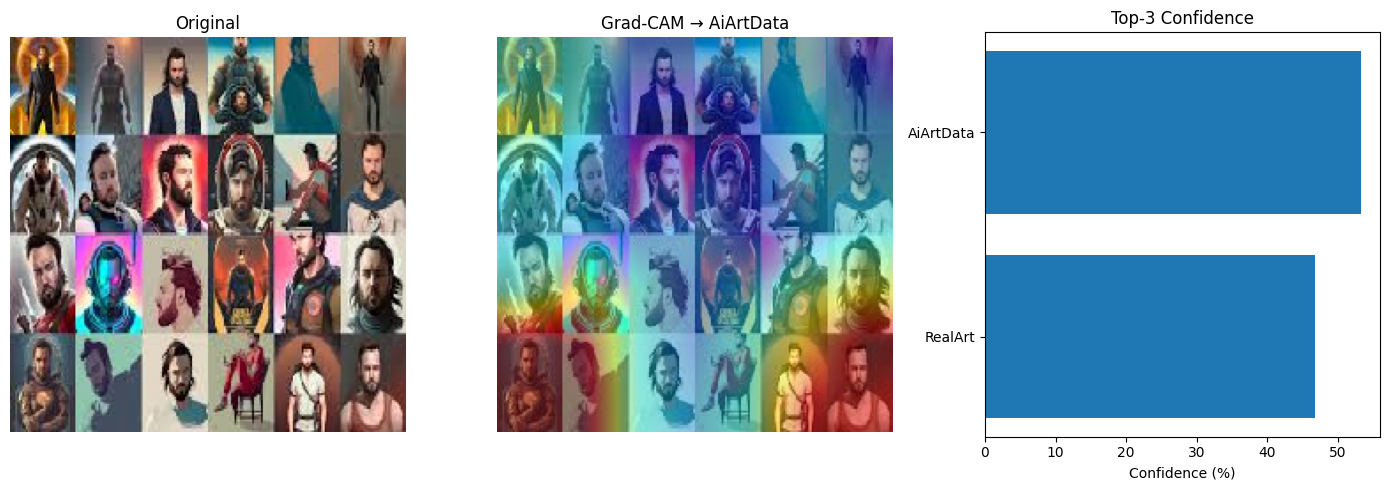


💾 Saved to: gradcam_outputs/images82.jpg
✅ Advanced pipeline completed successfully


In [3]:
advanced_predict_all()


#  MP4 Slideshow with Grad-CAM Overlay 


In [4]:

def gradcam_slideshow_to_mp4(
    output_video="artguard_ai_gradcam_slideshow.mp4",
    fps=1,
    max_images=40
):
    import os, cv2, numpy as np
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt

    print("🎬 Creating Grad-CAM slideshow video...")

    # -------------------------
    # Collect images
    # -------------------------
    image_files = []
    for root, dirs, files in os.walk(DATASET_PATH):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                image_files.append(os.path.join(root,f))

    if len(image_files) == 0:
        raise ValueError("No images found!")

    image_files = image_files[:max_images]

    class_names = list(train_gen.class_indices.keys())

    # -------------------------
    # Video writer
    # -------------------------
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(output_video, fourcc, fps, (IMG_SIZE, IMG_SIZE))

    # -------------------------
    # Safe Grad-CAM function
    # -------------------------
    def safe_gradcam(img_array, class_index):
        try:
            grad_model = tf.keras.models.Model(
                [model.inputs],
                [model.get_layer(last_conv_layer_name).output, model.output]
            )

            with tf.GradientTape() as tape:
                conv_out, preds = grad_model(img_array)

                if preds.shape[-1] == 1:
                    loss = preds[:, 0]
                else:
                    loss = preds[:, class_index]

            grads = tape.gradient(loss, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0,1,2))

            conv_out = conv_out[0]
            heatmap = conv_out @ pooled[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap, 0)
            max_val = tf.reduce_max(heatmap)

            if float(max_val) == 0.0:
                return None

            heatmap = (heatmap / max_val).numpy().astype("float32")

            if heatmap.ndim != 2:
                return None

            return heatmap

        except:
            return None

    # -------------------------
    # Process images
    # -------------------------
    for i, img_path in enumerate(image_files, 1):
        print(f"Processing {i}/{len(image_files)}")

        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_arr = image.img_to_array(img)
        inp = np.expand_dims(img_arr/255.0, 0)

        preds = model.predict(inp, verbose=0)[0]

        if preds.shape[-1] == 1:
            p = float(preds[0])
            probs = np.array([1-p, p])
        else:
            probs = preds

        class_idx = int(np.argmax(probs))
        pred_class = class_names[class_idx]
        confidence = probs[class_idx]*100

        # Grad-CAM
        heatmap = safe_gradcam(inp, class_idx)

        original = img_arr.astype(np.uint8)

        if heatmap is not None:
            heatmap = np.ascontiguousarray(heatmap, dtype=np.float32)
            heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
            heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
        else:
            overlay = original.copy()

        # Add text
        cv2.putText(overlay, f"{pred_class} ({confidence:.1f}%)",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        # Write frame
        video.write(cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    video.release()

    print("✅ Slideshow video created!")
    print("📁 Saved as:", output_video)
    print("⬇️ Download from Kaggle Output panel")

    return output_video


In [5]:
gradcam_slideshow_to_mp4()


🎬 Creating Grad-CAM slideshow video...
Processing 1/40


Processing 2/40


Processing 3/40


Processing 4/40


Processing 5/40


Processing 6/40


Processing 7/40


Processing 8/40


Processing 9/40


Processing 10/40


Processing 11/40


Processing 12/40


Processing 13/40


Processing 14/40


Processing 15/40


Processing 16/40


Processing 17/40


Processing 18/40


Processing 19/40


Processing 20/40


Processing 21/40


Processing 22/40


Processing 23/40


Processing 24/40


Processing 25/40


Processing 26/40


Processing 27/40


Processing 28/40


Processing 29/40


Processing 30/40


Processing 31/40


Processing 32/40


Processing 33/40


Processing 34/40


Processing 35/40


Processing 36/40


Processing 37/40


Processing 38/40


Processing 39/40


Processing 40/40


✅ Slideshow video created!
📁 Saved as: artguard_ai_gradcam_slideshow.mp4
⬇️ Download from Kaggle Output panel


'artguard_ai_gradcam_slideshow.mp4'